In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [3]:
input_path = "./"

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 5)).to(device)

In [6]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

In [7]:
image_datasets = {
    'train': datasets.ImageFolder(input_path + 'train', data_transforms['train']),
    'validation': datasets.ImageFolder(input_path + 'validation', data_transforms['validation'])
}

In [8]:
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),  # for Kaggle
    'validation': torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)  # for Kaggle
}

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [10]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [11]:
model_trained = train_model(model, criterion, optimizer, num_epochs=3)

Epoch 1/3
----------
train loss: 1.3394, acc: 0.4518
validation loss: 1.1824, acc: 0.5803
Epoch 2/3
----------
train loss: 1.0340, acc: 0.6235
validation loss: 1.0091, acc: 0.6112
Epoch 3/3
----------
train loss: 0.9132, acc: 0.6630
validation loss: 1.0123, acc: 0.6215


In [12]:
torch.save(model_trained.state_dict(), './pweights.h5')

In [13]:
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 5)).to(device)
model.load_state_dict(torch.load('./pweights.h5'))

<All keys matched successfully>

In [14]:
validation_img_paths = ["test/google_0002.jpg",
                        "test/google_0012.jpg",
                        "test/google_0013.jpg",
                        "test/google_0040.jpg",
                        "test/google_0017.jpg",
                        "test/naver_0050.jpg",
                       ]
img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]

In [15]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

In [16]:
pred_logits_tensor = model(validation_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[1.7211117e-01, 3.6802031e-02, 2.1782499e-02, 1.2675897e-02,
        7.5662845e-01],
       [5.7253629e-01, 6.7812771e-02, 5.1172610e-02, 4.1255979e-03,
        3.0435267e-01],
       [2.9948406e-02, 4.3238498e-02, 7.8914356e-01, 1.6415610e-03,
        1.3602795e-01],
       [7.1619436e-02, 2.4513905e-01, 4.6780995e-01, 8.3253614e-04,
        2.1459898e-01],
       [3.6112033e-03, 1.1733066e-03, 8.9215866e-04, 9.9174702e-01,
        2.5762515e-03],
       [1.2771910e-01, 6.0591620e-01, 1.3175604e-01, 1.1129568e-02,
        1.2347909e-01]], dtype=float32)

In [17]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

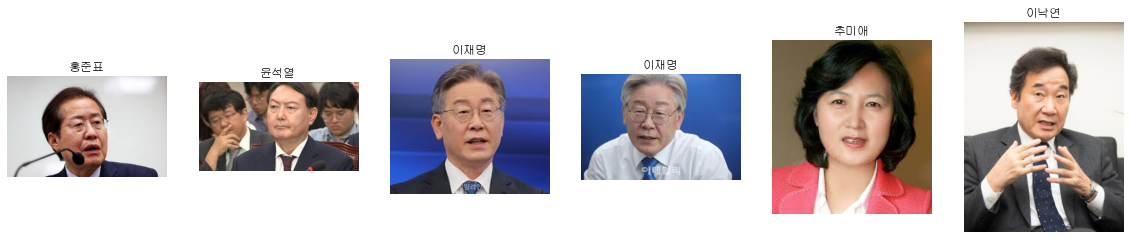

In [18]:
labels = ['윤석열','이낙연','이재명','추미애','홍준표']
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title(labels[np.argmax(pred_probs[i])])
    ax.imshow(img)